In [1]:
import os
import cv2
import sys
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.optim as optim
from PIL import  Image
import numpy as np 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
sys.path.append(os.path.abspath("../utils"))  #
from dataset import  CustomDataset
from loader import create_data_loaders
from metrics import calculate_metrics
from early_stopping import EarlyStopping
from visual import visualization
import time 

/Users/zekariamohamed/anaconda3/envs/yolov10/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Both image and mask folders exists
Image size: (512, 512), Width: 512, Height: 512


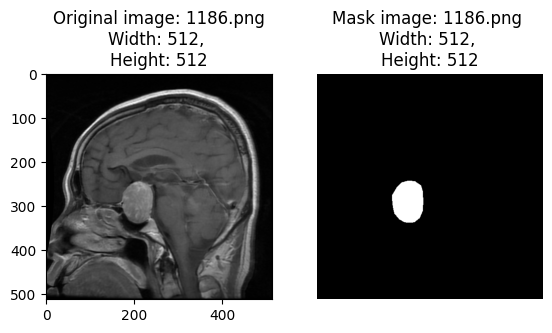

In [2]:
image_folder_path = "../Data/images" 
mask_folder_path = "../Data/masks"

image_paths = sorted([os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path)])
mask_paths = sorted([os.path.join(mask_folder_path, mask) for mask in os.listdir(mask_folder_path)])

if os.path.exists(image_folder_path) and os.path.exists(mask_folder_path):
    print("Both image and mask folders exists")
else:
    print("One of the folders does not exist")
    exit()


def get_image_size(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print("Image not found")
    else: 
        height, width = image.shape[:2]
        return height, width


#* image files 

image_files = os.listdir(image_folder_path)

if len(image_files)> 0:
    
    image_file = image_files[3]
    
    image_path = os.path.join(image_folder_path, image_file)
    mask_file = image_file
    mask_path = os.path.join(mask_folder_path, mask_file)
    
    image_size = get_image_size(image_path)
    
    if image_size is not None:
        print(f"Image size: {image_size}, Width: {image_size[0]}, Height: {image_size[1]}")
        
        #* loading the images and plot it 
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original image: {image_file}\nWidth: {image_size[0]}, \nHeight: {image_size[1]}")
        
        #* loading the mask and plot it 
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='grey')
        plt.title(f"Mask image: {mask_file} \nWidth: {image_size[0]}, \nHeight: {image_size[1]}")
        plt.axis('off')
        plt.show()
    else:
        print("Error reading images size") 
else:
    print("No images found in the folder")
    exit()  

In [3]:
#* splitting the dataset into train, val and test
val_ratio = 1 / 9
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.1, random_state=42)
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths, train_mask_paths, test_size=val_ratio, random_state=42)

train_loader, val_loader, test_loader = create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=32)

#* checking the data loaders 
print(f"training dataset: {len(train_loader.dataset)}")
print(f"validation dataset: {len(val_loader.dataset)}")
print(f"test dataset: {len(test_loader.dataset)}")

training dataset: 2450
validation dataset: 307
test dataset: 307


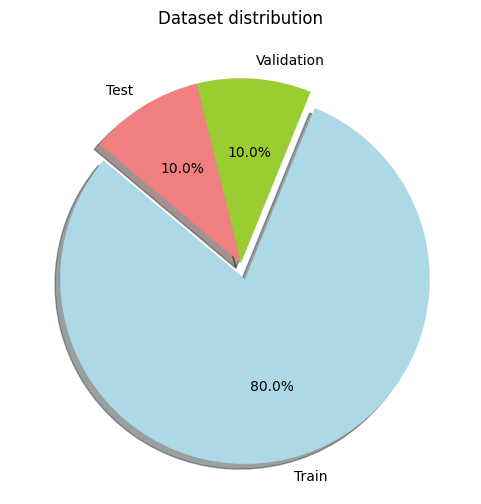

In [4]:
#* Dataset distribution
train_set_size = len(train_loader.dataset)
val_set_size = len(val_loader.dataset)
test_set_size =len(test_loader.dataset)

sizes = [train_set_size, val_set_size, test_set_size]
labels = ['Train', 'Validation', 'Test']
colors = ['lightblue', 'yellowgreen', 'lightcoral']
explode = (0.09, 0, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.gca().set_aspect('equal') 
plt.title("Dataset distribution")   
plt.show()


In [5]:
#* training the model 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using Device: {device}")

encoder_name = "resnet50"
encoder_weights = "imagenet"
in_channels = 3
classes = 1 
model = smp.DeepLabV3(
    
    encoder_name = encoder_name,
    encoder_weights = encoder_weights, 
    in_channels = in_channels,
    classes = classes
)


model.to(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, y_pred, y_true):
        # Apply sigmoid manually instead of logsigmoid().exp()
        y_pred = torch.sigmoid(y_pred)
        
        # Flatten
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        
        # Calculate Dice
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        
        return 1 - dice

#criterion = nn.BCEWithLogitsLoss() #* Binary cross Entropy 
criterion = DiceLoss() #* Dice loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30


Using Device: mps


In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping=None):
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []
    dice_values = []
    iou_values = []

    best_model_state = None
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Training pixel accuracy
            acc, _, _, _, _, _ = calculate_metrics(outputs, masks)
            running_acc += acc

        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)

        train_loss_values.append(avg_train_loss)
        train_acc_values.append(avg_train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_acc = 0.0
        val_dice_total = 0.0
        val_iou_total = 0.0

        with torch.no_grad():
            for val_images, val_masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                val_running_loss += val_loss.item()

                acc, _, _, _, iou, dice = calculate_metrics(val_outputs, val_masks)
                val_running_acc += acc
                val_dice_total += dice
                val_iou_total += iou

        avg_val_loss = val_running_loss / len(val_loader)
        avg_val_acc = val_running_acc / len(val_loader)
        avg_dice = val_dice_total / len(val_loader)
        avg_iou = val_iou_total / len(val_loader)

        val_loss_values.append(avg_val_loss)
        val_acc_values.append(avg_val_acc)
        dice_values.append(avg_dice)
        iou_values.append(avg_iou)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f} | Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

        if early_stopping is not None:
            early_stopping(avg_val_loss)
            if early_stopping.stop_training:
                print("Early stopping triggered!")
                break

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            print(f"New best model saved! Validation loss: {best_loss:.4f}")

    return (train_loss_values, val_loss_values,
            train_acc_values, val_acc_values,
            dice_values, iou_values,
            best_model_state)

In [7]:
def save_best_model(model_state, filename):
    torch.save(model_state, filename)

In [8]:
earlyStopping = EarlyStopping(patience=5, mode='min')
training_losses, val_losses, train_accs, val_accs, dice_values, iou_values, best_model_state = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, earlyStopping)
if best_model_state is not None:
    save_best_model(best_model_state, "best_deepLabV3_model.pth")


Epoch 1/30 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch 1/30 | Train Loss: 0.6545, Val Loss: 0.4255 | Train Acc: 0.9321, Val Acc: 0.9841 | Dice: 0.5932, IoU: 0.4223
New best model saved! Validation loss: 0.4255


Epoch 2/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch 2/30 | Train Loss: 0.3552, Val Loss: 0.3362 | Train Acc: 0.9889, Val Acc: 0.9897 | Dice: 0.6685, IoU: 0.5037
New best model saved! Validation loss: 0.3362


Epoch 3/30 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch 3/30 | Train Loss: 0.3205, Val Loss: 0.3239 | Train Acc: 0.9897, Val Acc: 0.9881 | Dice: 0.6828, IoU: 0.5202
New best model saved! Validation loss: 0.3239


Epoch 4/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch 4/30 | Train Loss: 0.2871, Val Loss: 0.3241 | Train Acc: 0.9908, Val Acc: 0.9901 | Dice: 0.6772, IoU: 0.5153


Epoch 5/30 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch 5/30 | Train Loss: 0.2850, Val Loss: 0.3069 | Train Acc: 0.9908, Val Acc: 0.9908 | Dice: 0.6929, IoU: 0.5328
New best model saved! Validation loss: 0.3069


Epoch 6/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 6/30 | Train Loss: 0.2533, Val Loss: 0.2708 | Train Acc: 0.9918, Val Acc: 0.9907 | Dice: 0.7329, IoU: 0.5809
New best model saved! Validation loss: 0.2708


Epoch 7/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 7/30 | Train Loss: 0.2564, Val Loss: 0.2861 | Train Acc: 0.9917, Val Acc: 0.9910 | Dice: 0.7154, IoU: 0.5607


Epoch 8/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 8/30 | Train Loss: 0.2356, Val Loss: 0.2650 | Train Acc: 0.9923, Val Acc: 0.9920 | Dice: 0.7342, IoU: 0.5828
New best model saved! Validation loss: 0.2650


Epoch 9/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 9/30 | Train Loss: 0.2381, Val Loss: 0.2645 | Train Acc: 0.9922, Val Acc: 0.9916 | Dice: 0.7373, IoU: 0.5873
New best model saved! Validation loss: 0.2645


Epoch 10/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch 10/30 | Train Loss: 0.2233, Val Loss: 0.2635 | Train Acc: 0.9928, Val Acc: 0.9915 | Dice: 0.7372, IoU: 0.5870
New best model saved! Validation loss: 0.2635


Epoch 11/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 11/30 | Train Loss: 0.2402, Val Loss: 0.2871 | Train Acc: 0.9921, Val Acc: 0.9898 | Dice: 0.7170, IoU: 0.5612


Epoch 12/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 12/30 | Train Loss: 0.2235, Val Loss: 0.2443 | Train Acc: 0.9928, Val Acc: 0.9924 | Dice: 0.7565, IoU: 0.6122
New best model saved! Validation loss: 0.2443


Epoch 13/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 13/30 | Train Loss: 0.2130, Val Loss: 0.2613 | Train Acc: 0.9930, Val Acc: 0.9919 | Dice: 0.7391, IoU: 0.5894


Epoch 14/30 - Validation: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 14/30 | Train Loss: 0.2032, Val Loss: 0.2419 | Train Acc: 0.9934, Val Acc: 0.9923 | Dice: 0.7582, IoU: 0.6130
New best model saved! Validation loss: 0.2419


Epoch 15/30 - Validation: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Epoch 15/30 | Train Loss: 0.2038, Val Loss: 0.2402 | Train Acc: 0.9933, Val Acc: 0.9922 | Dice: 0.7608, IoU: 0.6169
New best model saved! Validation loss: 0.2402


Epoch 16/30 - Validation: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Epoch 16/30 | Train Loss: 0.1965, Val Loss: 0.2253 | Train Acc: 0.9936, Val Acc: 0.9923 | Dice: 0.7764, IoU: 0.6365
New best model saved! Validation loss: 0.2253


Epoch 17/30 - Validation: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Epoch 17/30 | Train Loss: 0.1988, Val Loss: 0.2215 | Train Acc: 0.9935, Val Acc: 0.9931 | Dice: 0.7784, IoU: 0.6399
New best model saved! Validation loss: 0.2215


Epoch 18/30 - Validation: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Epoch 18/30 | Train Loss: 0.1977, Val Loss: 0.2555 | Train Acc: 0.9935, Val Acc: 0.9919 | Dice: 0.7445, IoU: 0.5969


Epoch 19/30 - Validation: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Epoch 19/30 | Train Loss: 0.1881, Val Loss: 0.2150 | Train Acc: 0.9939, Val Acc: 0.9929 | Dice: 0.7859, IoU: 0.6491
New best model saved! Validation loss: 0.2150


Epoch 20/30 - Validation: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Epoch 20/30 | Train Loss: 0.1811, Val Loss: 0.2602 | Train Acc: 0.9941, Val Acc: 0.9918 | Dice: 0.7397, IoU: 0.5905


Epoch 21/30 - Validation: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch 21/30 | Train Loss: 0.1890, Val Loss: 0.2188 | Train Acc: 0.9938, Val Acc: 0.9927 | Dice: 0.7820, IoU: 0.6436


Epoch 22/30 - Validation: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Epoch 22/30 | Train Loss: 0.1859, Val Loss: 0.2345 | Train Acc: 0.9939, Val Acc: 0.9921 | Dice: 0.7673, IoU: 0.6256


Epoch 23/30 - Validation: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Epoch 23/30 | Train Loss: 0.1796, Val Loss: 0.2288 | Train Acc: 0.9941, Val Acc: 0.9927 | Dice: 0.7718, IoU: 0.6317


Epoch 24/30 - Validation: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch 24/30 | Train Loss: 0.1755, Val Loss: 0.2432 | Train Acc: 0.9942, Val Acc: 0.9928 | Dice: 0.7560, IoU: 0.6118
Early stopping the training process.
Early stopping triggered!


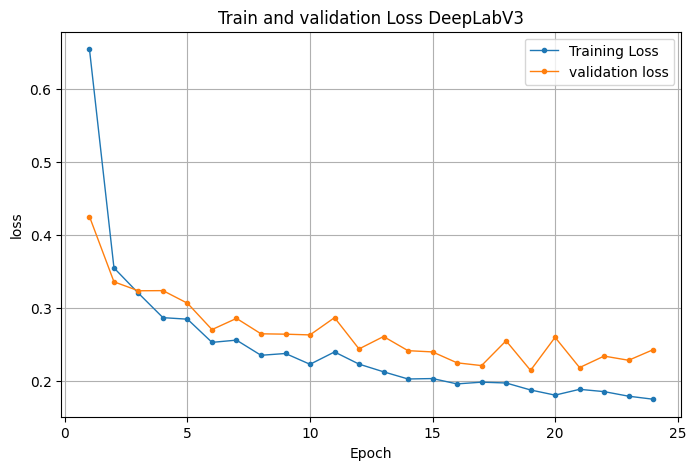

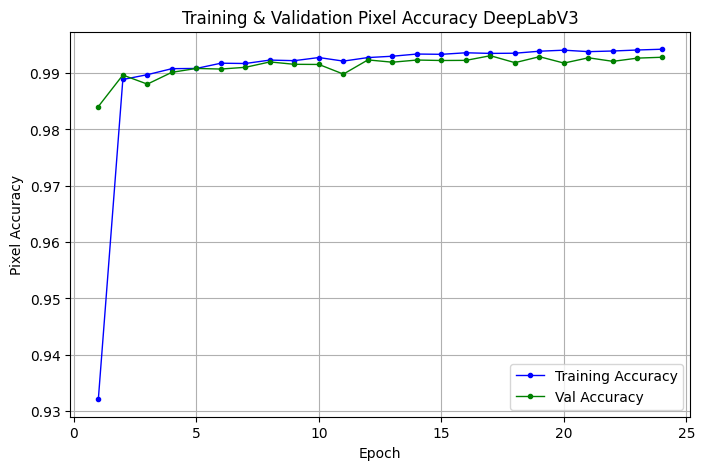

/var/folders/4g/tf_931w11w99w336_dt_g9740000gn/T/ipykernel_87158/2653565202.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, len(iou_values)+1), iou_values, '-', label = "IoU", color = "orange", marker='o', markersize=3, linestyle='-', linewidth=1)
/var/folders/4g/tf_931w11w99w336_dt_g9740000gn/T/ipykernel_87158/2653565202.py:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, len(dice_values)+1), dice_values, '-', label = "Dice Coefficient", color= "purple", marker='o', markersize=3, linestyle='-', linewidth=1)


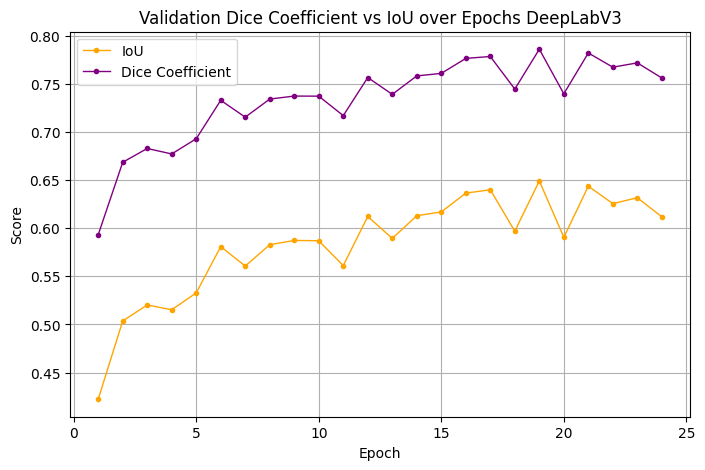

In [13]:
epochs = range(1, len(training_losses)+1)

plt.figure(figsize=(8, 5))

plt.plot(epochs,  training_losses, label="Training Loss", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(epochs, val_losses, label = "validation loss", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.title("Train and validation Loss DeepLabV3")
plt.legend()
plt.grid(True)
plt.show()
 


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label = "Training Accuracy", color = "blue", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(epochs, val_accs, label= "Val Accuracy", color= "green", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Training & Validation Pixel Accuracy DeepLabV3")
plt.legend()
plt.grid(True)
plt.show()
 

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(iou_values)+1), iou_values, '-', label = "IoU", color = "orange", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(range(1, len(dice_values)+1), dice_values, '-', label = "Dice Coefficient", color= "purple", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Dice Coefficient vs IoU over Epochs DeepLabV3")
plt.legend()
plt.grid(True)


 
plt.show()

In [10]:
checkpoint = torch.load("best_deepLabV3_model.pth", map_location=device)
model.load_state_dict(checkpoint)  # ✅ This loads weights into the model
model.eval()

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [11]:
#* Here performing the warm-up test  which is useful when measuring the inference time of the model
warmup_iterations = 10
model.eval()
with torch.no_grad():
    for _ in range(warmup_iterations):
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            if device.type == "mps":
                torch.tensor(0).to(device)  # Warm up the GPU
            break

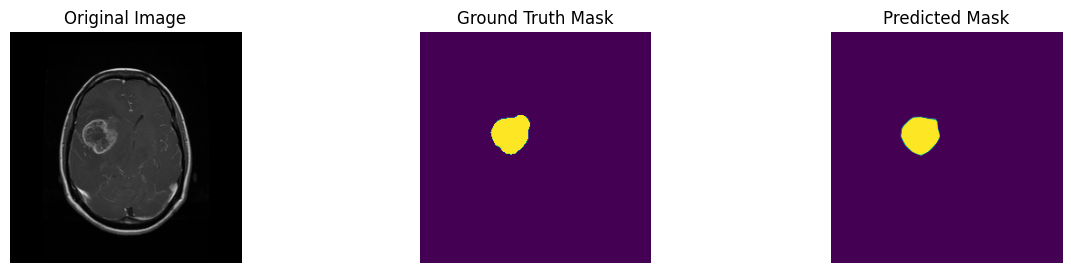

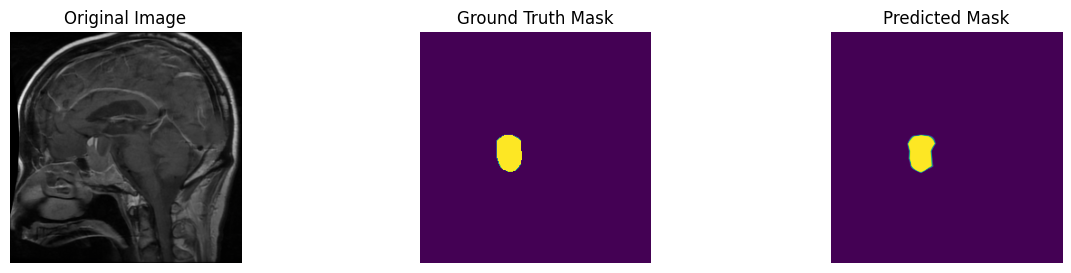

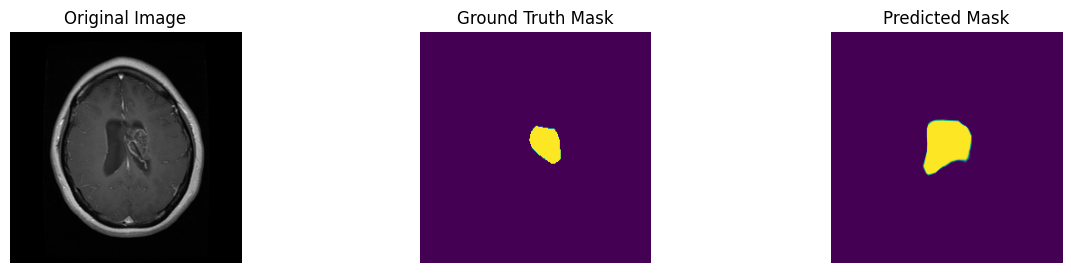

Performance Metrics DeepLabV3:
Average Inference time per batch (MPS): 1.1702 seconds
Average Inference time per image (MPS): 0.0381 seconds
Average: Pixel Accuracy for test set: 99.40
Average: Precision for test set: 81.99
Average: Recall for test set: 74.30
Average: F1-score for test set: 75.43
Average: IoU for test set: 66.53
Average: Dice for test set: 75.43


In [15]:

iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
pixel_acc_scores = []
inference_times = []


with torch.no_grad():
    model.eval()
    for batch_idx, (images, masks) in enumerate (test_loader): 
        
        images = images.to(device)
        masks  = masks.to(device)
        
        
        start_time = time.time()
        
        predications = model(images)
        if device.type == "mps":
            torch.tensor(0).to(device)
        
        end_time = time.time()
        inference_times.append(end_time - start_time)
        predications = torch.sigmoid(predications)
        
        for i in range(len(images)):
            
            pixel_acc, precision, recall, f1_score, iou, dice = calculate_metrics(predications[i], masks[i])
            iou_scores.append(iou)
            dice_scores.append(dice)
            precision_scores.append(precision)  
            recall_scores.append(recall)
            f1_scores.append(f1_score)
            pixel_acc_scores.append(pixel_acc)
        
        
            if batch_idx < 3 and i == 0:
                #* visualization of the first three images
                visualization(images[i], masks[i], predications[i])


#*calculating the average of the iou 

average_inference_time = sum(inference_times) / len(inference_times)
average_inference_time_per_image = sum(inference_times) / len(test_loader.dataset)
average_pixel_acc = sum(pixel_acc_scores) / len(pixel_acc_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)
average_iou = sum(iou_scores)/len(iou_scores)
average_dice = sum(dice_scores) / len(dice_scores)


print(f"Performance Metrics DeepLabV3:")
print(f"Average Inference time per batch (MPS): {average_inference_time:.4f} seconds")
print(f"Average Inference time per image (MPS): {average_inference_time_per_image:.4f} seconds")
print(f"Average: Pixel Accuracy for test set: {average_pixel_acc * 100:.2f}")
print(f"Average: Precision for test set: {average_precision * 100:.2f}")
print(f"Average: Recall for test set: {average_recall * 100:.2f}")
print(f"Average: F1-score for test set: {average_f1 * 100:.2f}")
print(f"Average: IoU for test set: {average_iou * 100:.2f}")
print(f"Average: Dice for test set: {average_dice * 100:.2f}")

